In [45]:
install.packages("qqman")

also installing the dependency ‘calibrate’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [54]:
install.packages("gap")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [89]:
install.packages("gridExtra")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [100]:
install.packages("wtest")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [101]:
library(dplyr)
library(ggplot2)
library(gap)
library(qqman)
library(SNPRelate)
library(wtest)
library(gridExtra)

In [20]:
nonbinary = read.table('eye_color.txt', header = F)
fam = read.table('eye_color.fam')
new.levels = c(2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2)
FID = fam$V1
IID = nonbinary[,1]
phenotype = new.levels[factor(nonbinary$V2)]
write.table(data.frame(FID, IID, phenotype), file = 'binary_phenotype_brown.txt', col.names = T, row.names = F, quote = F)

## QC 
#### Missing data

Testing for missing data with the option --missing in plink

In [ ]:
plink --allow-no-sex --bfile eye_color --missing --out eye_color

This creates the files eye_color.imiss and eye_color.lmiss
To analyse the heterozygosity of the sample --het is used

plink --allow-no-sex --bfile eye_color --het --out eye_color

The resulting .het file contains the observed number of homozygous genotypes as well as the number of non-missing genotypes per individual. With these values the observed heterozygosity rate per individual can be calculated using the this formula:
$𝑜𝑏𝑠_{ℎ𝑒𝑡} = \frac{𝑁(𝑁𝑀) − 𝑂(𝐻𝑜𝑚)}{𝑁(𝑁𝑀)}$
This is calculated in R and plotted with the proportion of missing SNPs per individuals (F_MISS in .imiss) as a function of the observed heterozygosity rate per individual.

In [21]:
imiss = read.table('eye_color.imiss', header = T, sep="")
het = read.table('eye_color.het', header = T, sep="")

In [22]:
het$obs_het = (het$N.NM. - het$O.HOM.)/het$N.NM.
mean_het = mean(het$obs_het)
sd_het = sd(het$obs_het)

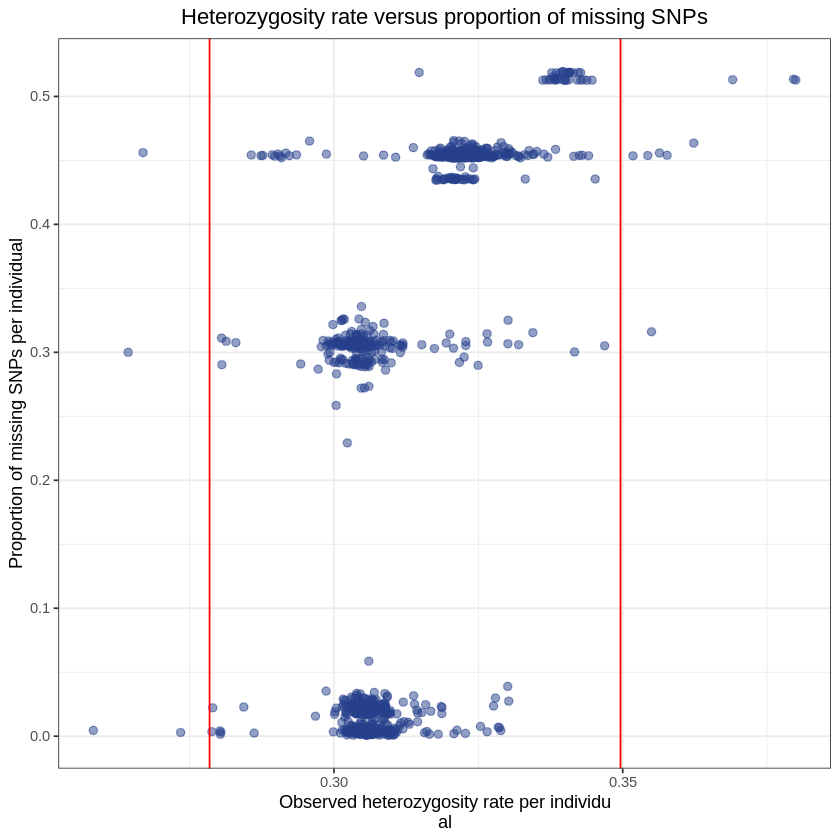

In [23]:
ggplot(data = het, aes(x = obs_het, y = imiss$F_MISS)) +
 geom_point(color='royalblue4', size=2, alpha=0.5) +
 labs(y = "Proportion of missing SNPs per individual", x = "Observed heterozygosity rate per individu
al") +
 geom_vline(xintercept = mean_het + 3*sd_het, color = "red") +
 geom_vline(xintercept = mean_het - 3*sd_het, color = "red") +
 theme_bw() +
 labs(title = "Heterozygosity rate versus proportion of missing SNPs") +
 theme(plot.title = element_text(hjust = 0.5))


The vertical lines indicate heterozygosity rates 3 standard deviations above and below the mean.
To filter out samples that are outside these lines, a file containing the FID and IID of these individuals is generated.


In [24]:
right_tail = mean_het + 3*sd(het$obs_het)
left_tail = mean_het - 3*sd(het$obs_het)
filtering = cbind(imiss, het)
outlier_ind = subset(filtering, filtering$obs_het > right_tail | filtering$obs_het < left_tail)
write.table(outlier_ind[,c(1,2)], 'wrong_het_missing_values.txt', col.names = FALSE, row.names = FALSE)

This is then removed from the sample using plink

In [ ]:
plink --allow-no-sex --bfile eye_color --remove wrong_het_missing_values.txt --pheno binary_phenotype_brown.txt --make-bed --out eye_color_het

13 individuals were filtered out by doing this leaving us with 1274.

#### Relatedness

The remaining individuals in the sample are then analysed for relatedness, which is done by first
using the plink option –indep-pairwise. This creates a prune.in file, which is used to compute the IBD
matrix

In [ ]:
plink --allow-no-sex --bfile eye_color_het --indep-pairwise 500kb 5 0.2 --out eye_color_het
plink --allow-no-sex --bfile eye_color_het --extract eye_color_het.prune.in --genome --min 0.185 --out eye_color_het

To remove the individuals with an IBD larger than 0.185, a .txt file is created in R.

In [25]:
ibd = read.table('eye_color_het.genome', header = TRUE)
members = ibd[,1]
members = unique(members)
write.table(cbind(members,members), file = 'wrong_ibd.txt', col.names = F, row.names = F)

In [ ]:
The individuals listed in wrong_ibd.txt are then removed using plink.

In [ ]:
plink --allow-no-sex --bfile eye_color_het --remove wrong_ibd.txt --make-bed --out eye_color_het_ibd

1260 people are left in the data.

#### Variant filtering

Recomputing the missing data for each variant.

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd --missing --out eye_color_het_ibd

With the phenotype file, the Fisher’s exact test is performed on the case/control missing call counts

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd --pheno binary_phenotype_brown.txt --test-missing --out eye_color_het_ibd

In [26]:
test_missing = read.table('eye_color_het_ibd.missing', header = TRUE)
fail_diffmiss_qc = test_missing[test_missing$P < 10e-5, 2]
write.table(fail_diffmiss_qc, file = 'fail-diffmiss-qc.txt', row.names = F, col.names = F)


These variants are then filtered out along with any other that has a missing genotype rate larger than
0.05, deviates from Hardy-Weinberg equilibrium or has a minor allele frequency of less than 0.01.

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd --exclude fail-diffmiss-qc.txt --pheno binary_phenotype_brown.txt --geno 0.5 --hwe 0.00001 --maf 0.01 --make-bed --out eye_color_het_ibd_var

This leaves 783902 variants.

### PCA

In [32]:
snpgdsBED2GDS("eye_color_het_ibd_var.bed","eye_color_het_ibd_var.fam","eye_color_het_ibd_var.bim", "eye_color.gds")

Start file conversion from PLINK BED to SNP GDS ...
    BED file: 'eye_color_het_ibd_var.bed'
        SNP-major mode (Sample X SNP), 235.5M
    FAM file: 'eye_color_het_ibd_var.fam'
    BIM file: 'eye_color_het_ibd_var.bim'
Mon May 24 12:09:34 2021     (store sample id, snp id, position, and chromosome)
    start writing: 1260 samples, 783902 SNPs ...
[==================================================] 100%, completed, 16s
Mon May 24 12:09:50 2021 	Done.
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'eye_color.gds' (239.7M)
    # of fragments: 39
    save to 'eye_color.gds.tmp'
    rename 'eye_color.gds.tmp' (239.7M, reduced: 252B)
    # of fragments: 18


Pruning the data for PCA

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd_var --indep-pairwise 500kb 5 0.2 --out eye_color_het_ibd_var
plink --allow-no-sex --bfile eye_color_het_ibd_var --pheno binary_phenotype_brown.txt --extract eye_color_het_ibd_var.prune.in --pca 50 --out eye_color_het_ibd_var

In [33]:
n_pcs <- min(1260, 783902)

In [34]:
genofile <- snpgdsOpen("eye_color.gds",  FALSE, TRUE, TRUE)
pca <- snpgdsPCA(genofile,eigen.cnt=n_pcs)
summary(pca)

Principal Component Analysis (PCA) on genotypes:
Excluding 962 SNPs on non-autosomes
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 1,260
    # of SNPs: 782,940
    using 1 thread
    # of principal components: 1260
PCA:    the sum of all selected genotypes (0,1,2) = 372163512
CPU capabilities: Double-Precision SSE2
Mon May 24 12:10:47 2021    (internal increment: 2464)
[==================================================] 100%, completed, 6.4m
Mon May 24 12:17:09 2021    Begin (eigenvalues and eigenvectors)
Mon May 24 12:17:13 2021    Done.


          Length  Class  Mode     
sample.id    1260 -none- numeric  
snp.id     782940 -none- character
eigenval     1260 -none- numeric  
eigenvect 1587600 -none- numeric  
varprop      1260 -none- numeric  
TraceXTX        1 -none- numeric  
Bayesian        1 -none- logical  
genmat          0 -none- NULL     

In [35]:
eigenvectors <- as.data.frame(pca$eigenvect)
colnames(eigenvectors) <- as.vector(sprintf("PC%s", seq(1:nrow(pca$eigenvect))))
pca$sample.id <- sub("_eye_color_het_ibd_var_piece_dedup", "", pca$sample.id)
pca_percent <- pca$varprop*100

In [14]:
simpler.levels = c("Brown", "Other", "Other", "Other", "Other", "Other", "Brown", "Other", "Brown", "Other
", "Other", "Brown")

In [36]:
write.table(data.frame(FID, IID, eye_color = simpler.levels[factor(nonbinary$V2)]), file = 'simpler_eye_color.txt', col.names = T, row.names = F, quote = F)
info <- read.table("simpler_eye_color.txt", header = T)
eigenvectors$Phenotype <- info[match(pca$sample.id, info$IID),]$eye_color 

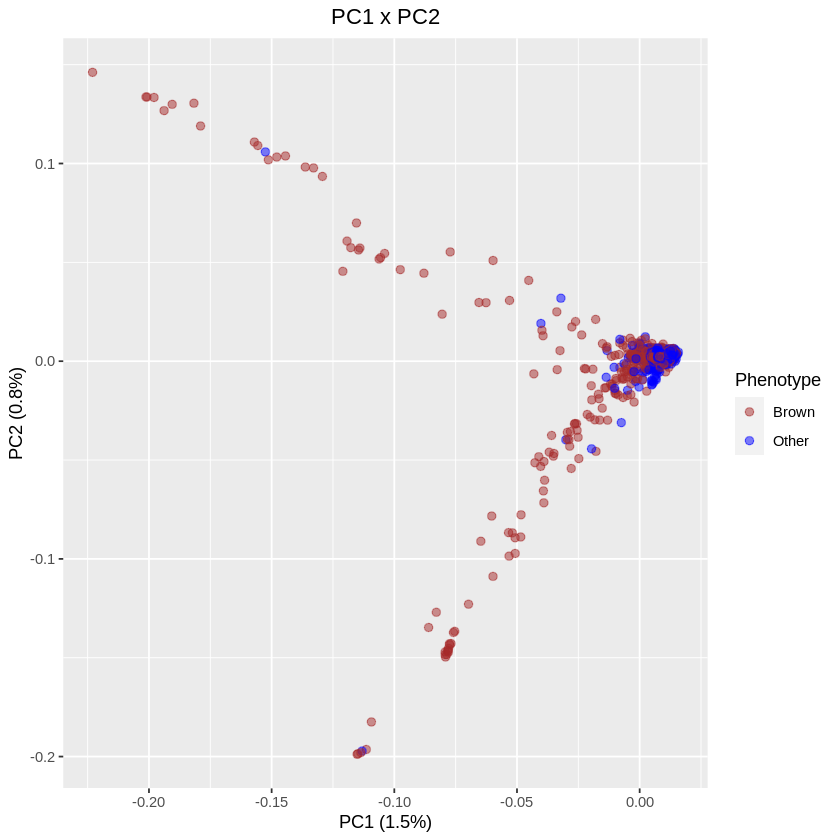

In [37]:
PC1_var <- pca$varprop[1]*100
PC2_var <- pca$varprop[2]*100

ggplot(data = eigenvectors, aes(x = PC1, y = PC2, col = Phenotype)) +
 geom_point(size=2,alpha=0.5) +
 scale_color_manual(breaks = c("Brown", "Other"), values=c("brown", "blue")) +
 xlab("PC1 (1.5%)") + ylab("PC2 (0.8%)") +
 labs(title = "PC1 x PC2") +
 theme(plot.title = element_text(hjust = 0.5))

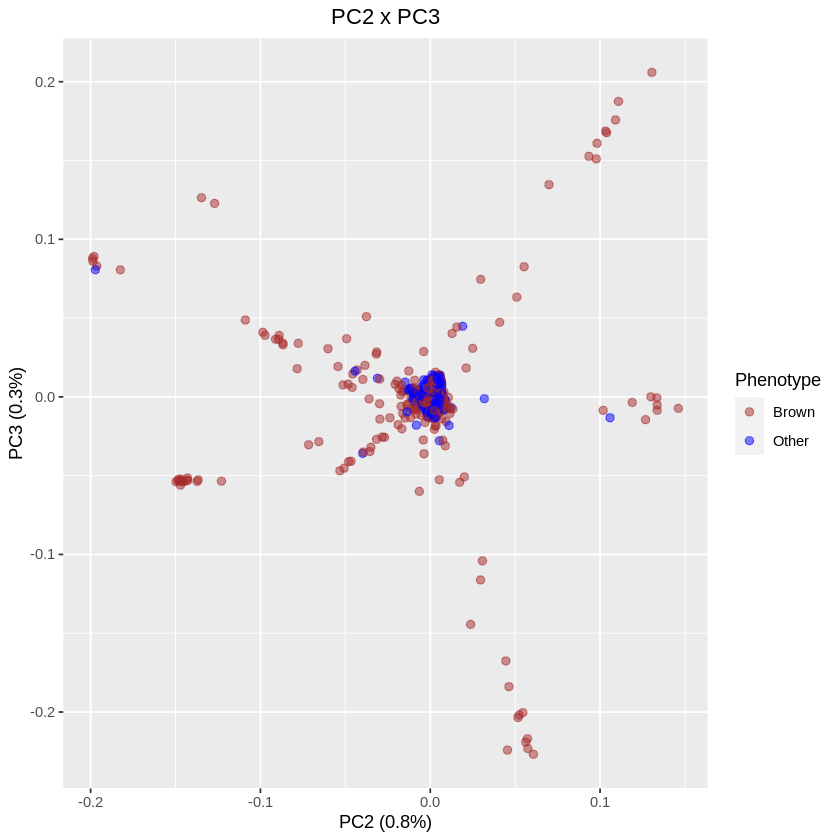

In [38]:
ggplot(data = eigenvectors, aes(x = PC2, y = PC3, col = Phenotype)) +
    geom_point(size=2,alpha=0.5) +
    scale_color_manual(breaks = c("Brown", "Other"), values=c("brown", "blue")) +
    xlab("PC2 (0.8%)") + ylab("PC3 (0.3%)") +
    labs(title = "PC2 x PC3") +
    theme(plot.title = element_text(hjust = 0.5))

## Test for association

Fisher's exact test

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd_var --pheno binary_phenotype_brown.txt --fisher --out eye_color_het_ibd_var_brown

p values plotted in Manhattan and QQ plot with Bonferroni corrected significance level

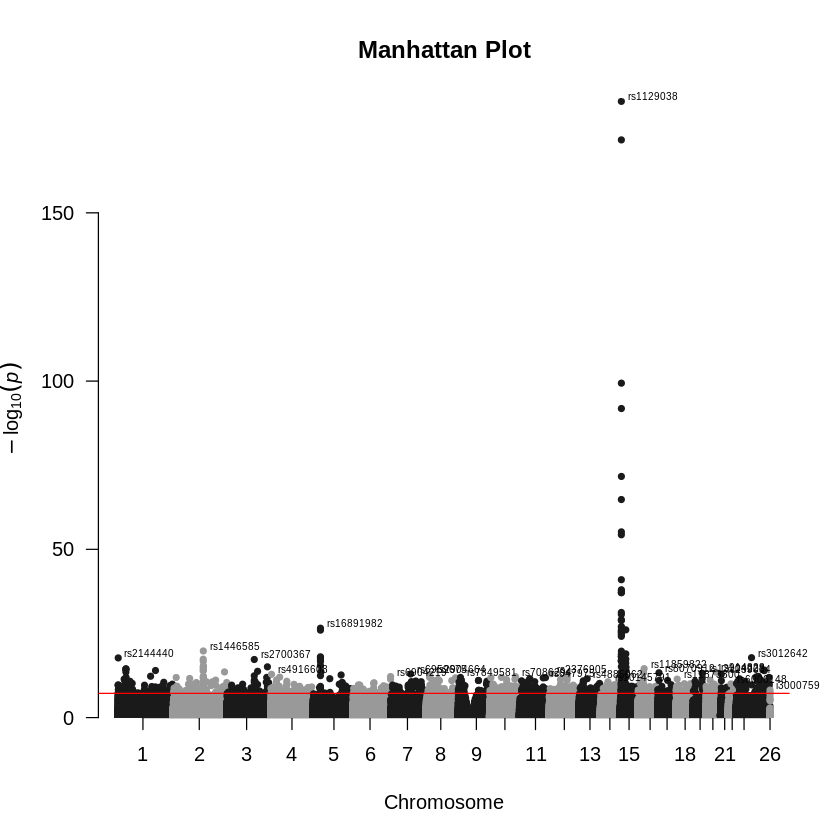

In [47]:
association_test = read.table("eye_color_het_ibd_var_brown.assoc.fisher", header = T)
corrected_level <- 0.05/length(association_test$SNP)
manhattan(association_test, suggestiveline = FALSE, main = "Manhattan Plot", genomewideline = -log10(corrected_level), annotatePval = corrected_level)

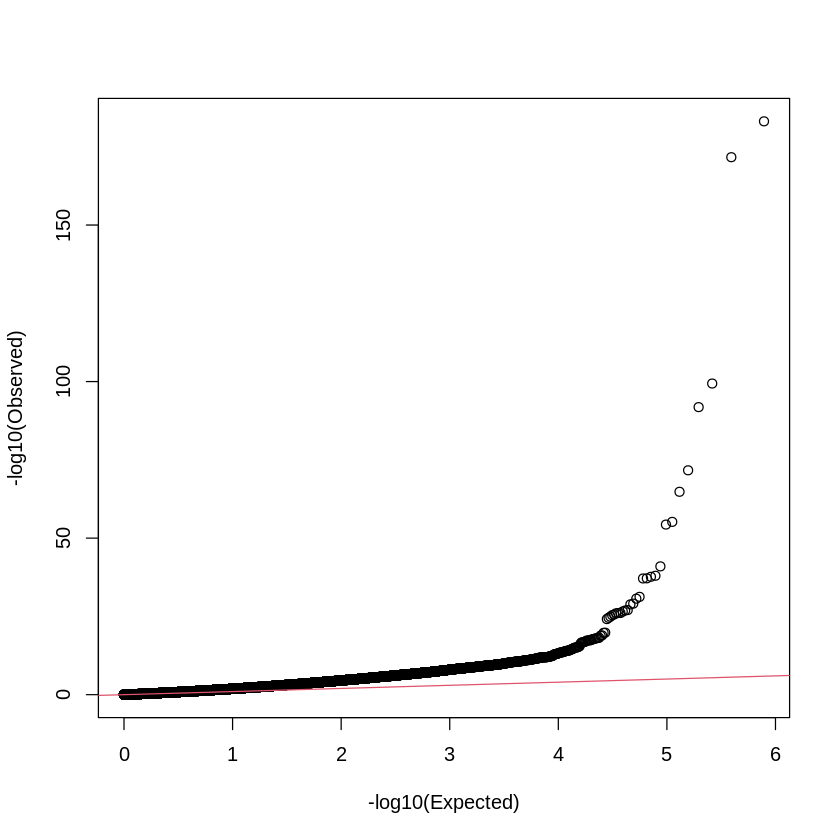

In [56]:
r <- gcontrol2(association_test$P, col="black")

In [61]:
(inflationfactor <- r$lambda)

[1] 2.037179

In [62]:
association_test$GC  <- association_test$P/inflationfactor

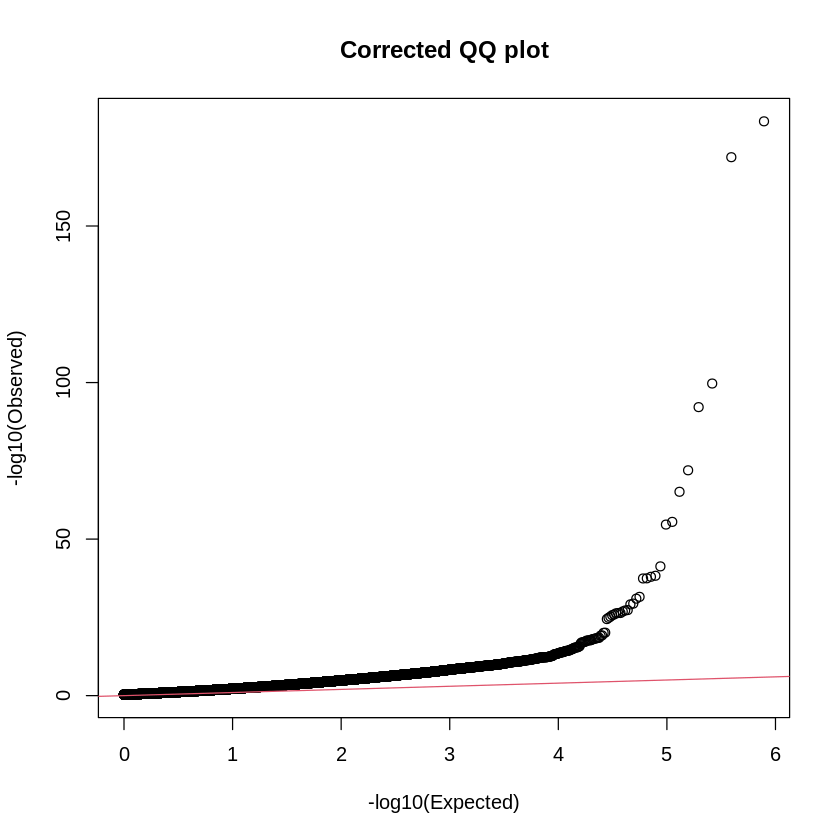

In [67]:
gcontrol2(association_test$GC, col="black", main = "Corrected QQ plot")

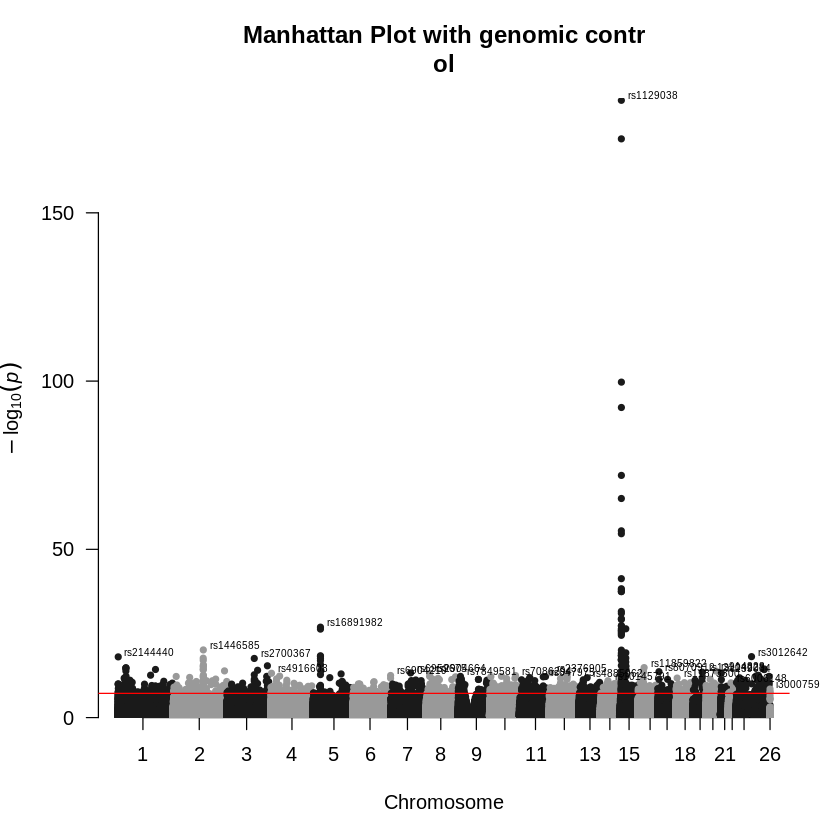

In [68]:
manhattan(association_test, p = "GC", suggestiveline = FALSE, main = "Manhattan Plot with genomic contr
ol", genomewideline = -log10(corrected_level), annotatePval = corrected_level)

#### PC adjusting

First 20

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd_var --pheno binary_phenotype_brown.txt --logistic --covar eye_color_het_ibd_var.eigenvec --covar-number 1-20 --out eye_color_het_ibd_var_brown_20

QQplot and Manhattanplot

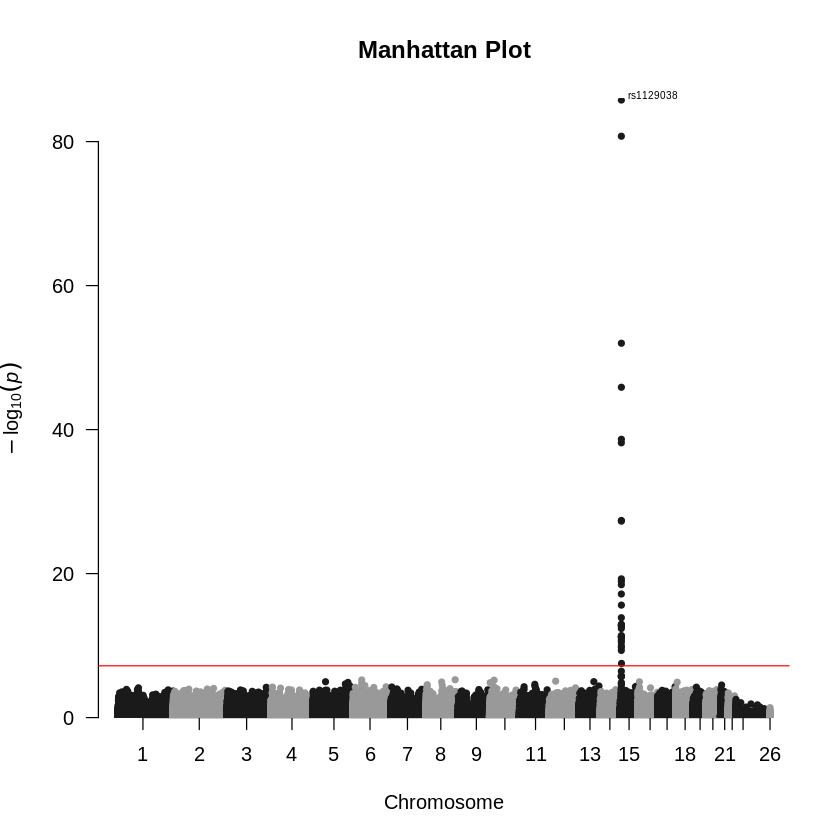

In [69]:
log_regres_20 <- read.table("eye_color_het_ibd_var_brown_20.assoc.logistic", header = T)
only_snp_20 <- na.omit(subset(log_regres_20, TEST=="ADD"))
manhattan(only_snp_20, suggestiveline = FALSE, main = "Manhattan Plot", genomewideline = -log10(0.05/length(only_snp_20$SNP)), annotatePval = 0.05/length(only_snp_20$SNP))

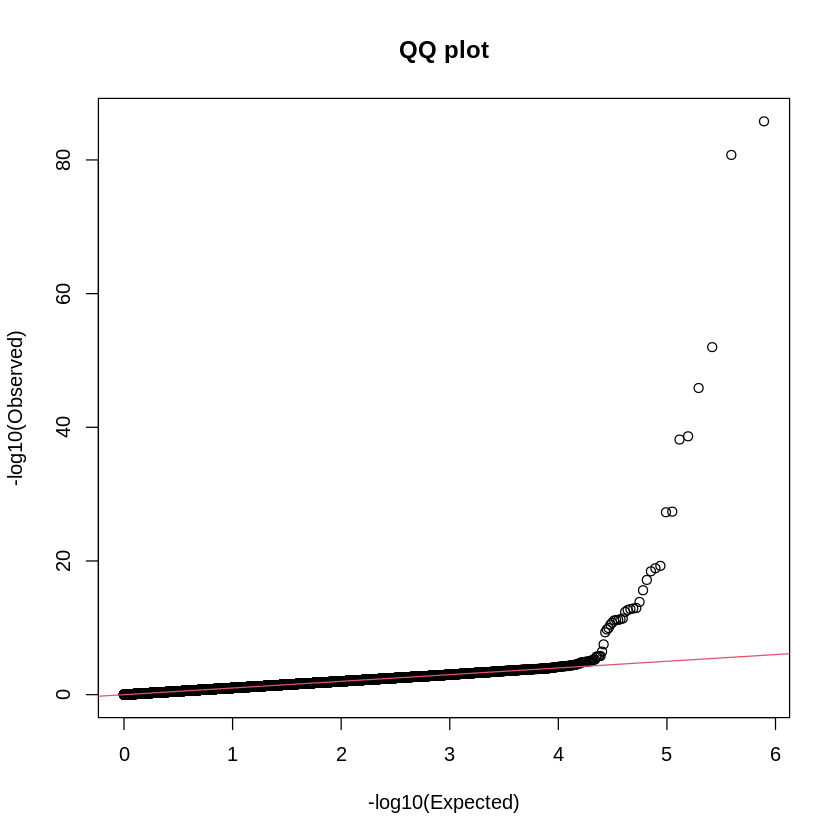

In [70]:
cov_20 <- gcontrol2(only_snp_20$P, col="black", main = "QQ plot")

In [71]:
cov_20$lambda

[1] 1.01643

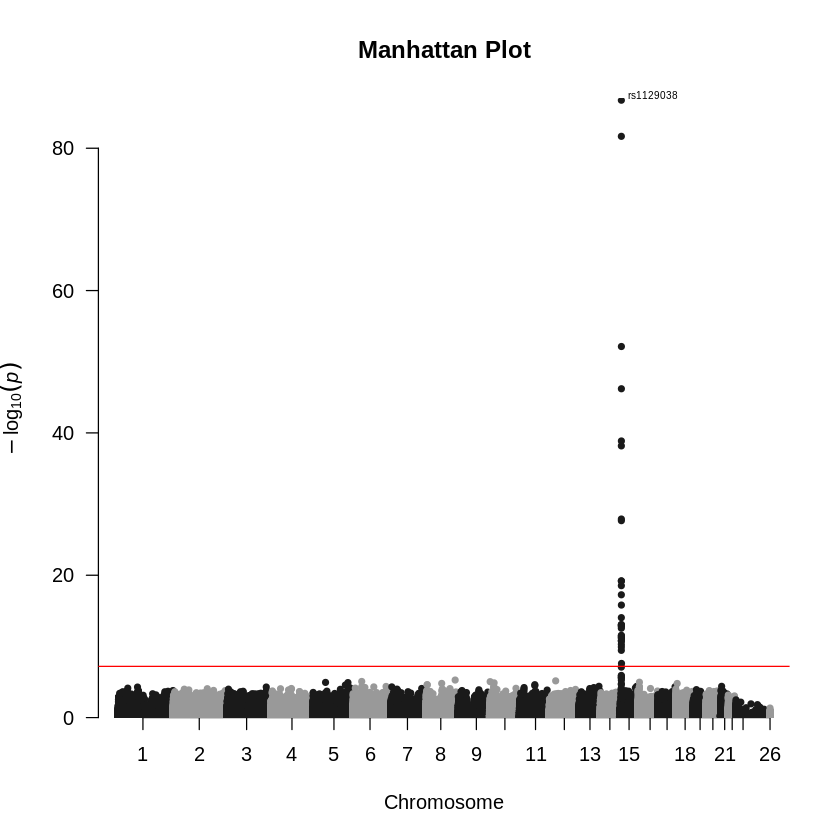

In [72]:
log_regres_10 <- read.table("eye_color_het_ibd_var_brown_10.assoc.logistic", header = T)
only_snp_10 <- na.omit(subset(log_regres_10, TEST=="ADD"))
manhattan(only_snp_10, suggestiveline = FALSE, main = "Manhattan Plot", genomewideline = -log10(0.05/length(only_snp_10$SNP)), annotatePval = 0.05/length(only_snp_10$SNP))

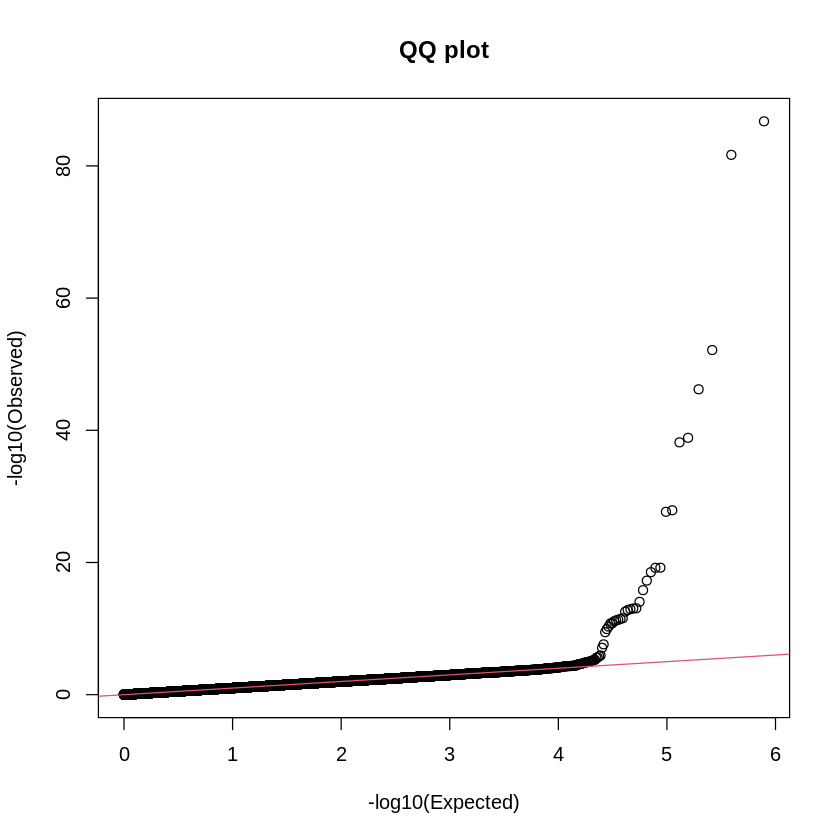

In [73]:
cov_10 <- gcontrol2(only_snp_10$P, col="black", main = "QQ plot")

In [76]:
cov_10$lambda

[1] 1.008427

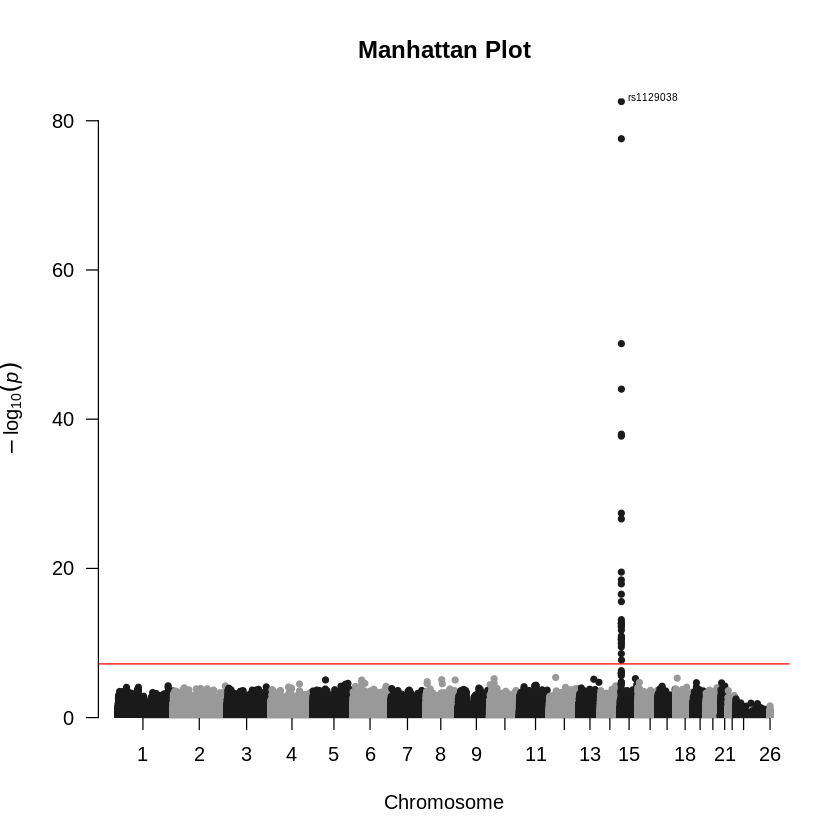

In [74]:
log_regres_30 <- read.table("eye_color_het_ibd_var_brown_30.assoc.logistic", header = T)
only_snp_30 <- na.omit(subset(log_regres_30, TEST=="ADD"))
manhattan(only_snp_30, suggestiveline = FALSE, main = "Manhattan Plot", genomewideline = -log10(0.05/length(only_snp_30$SNP)), annotatePval = 0.05/length(only_snp_30$SNP))

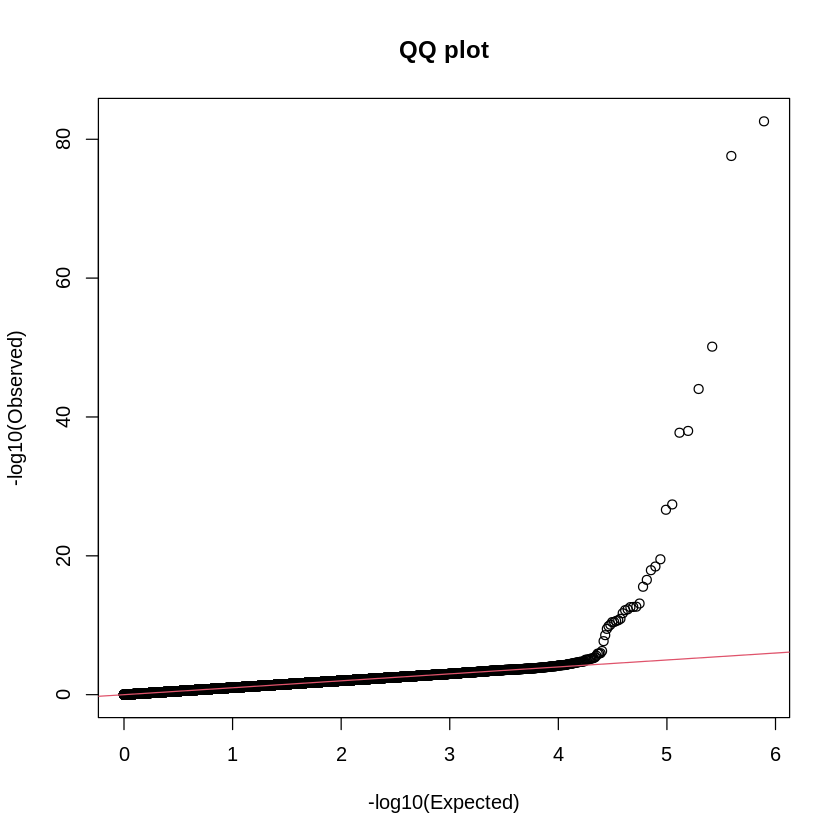

In [75]:
cov_30 <- gcontrol2(only_snp_30$P, col="black", main = "QQ plot")

In [77]:
cov_30$lambda

[1] 1.02353

Most significant SNP, 30 kb around it

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd_var --pheno binary_phenotype_brown.txt --recode A --snp rs1129038 --window 30 --out eye_color_het_ibd_var_brown

Genotype distributions

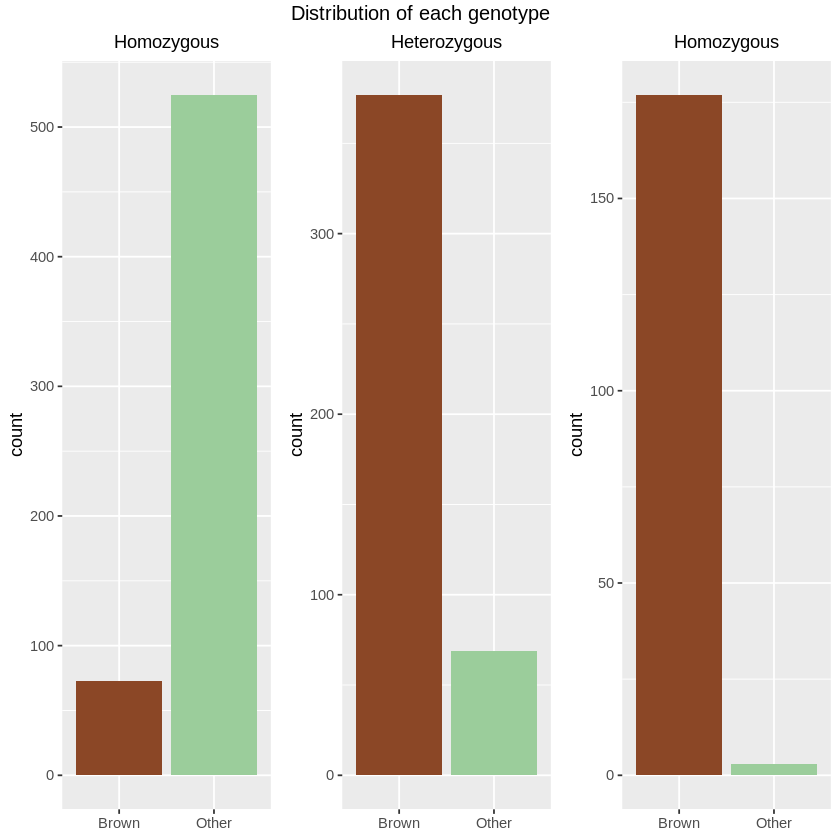

In [102]:
d <- read.table("eye_color_het_ibd_var_brown.raw", header = T)
d <- d %>% mutate(pheno = ifelse(PHENOTYPE == 2, "Brown", "Other"))

snp0 <- d %>% filter(d$rs1129038_C == 0)
snp1 <- d %>% filter(d$rs1129038_C == 1)
snp2 <- d %>% filter(d$rs1129038_C == 2)

l <- ggplot(snp0, aes(x = pheno, fill = pheno)) +
 geom_bar(fill = c('sienna4', 'darkseagreen3')) +
 theme(axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, size = 11)) + guides(fill=FALSE) + ggtitle("Homozygous")

m <- ggplot(snp1, aes(x = pheno, fill = pheno)) +
 geom_bar(fill = c('sienna4', 'darkseagreen3')) +
 theme(axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, size = 11)) + guides(fill=FALSE) + ggtitle("Heterozygous")

n <- ggplot(snp2, aes(x = pheno, fill = pheno)) +
 geom_bar(fill = c('sienna4', 'darkseagreen3')) +
 theme(axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, size = 11)) + guides(fill=FALSE) + ggtitle("Homozygous")

grid.arrange(l, m, n, ncol=3, top = "Distribution of each genotype")

# Epistasis test

In [ ]:
plink --allow-no-sex --bfile eye_color_het_ibd_var --fast-epistasis --out eye_color_brown

Heatmap corrected

ERROR: Error in library(wtest): there is no package called ‘wtest’
